In [0]:
# Importing necessary libraries

import tensorflow as tf
import os

In [0]:
# Analysis on the number of images in each category 

train_buildings = os.path.join('/content/seg_train/seg_train/buildings')
train_forest = os.path.join('/content/seg_train/seg_train/forest')
train_glacier = os.path.join('/content/seg_train/seg_train/glacier')
train_mountain =os.path.join('/content/seg_train/seg_train/mountain')
train_sea = os.path.join('/content/seg_train/seg_train/sea')
train_street = os.path.join('/content/seg_train/seg_train/street')

In [55]:
print('Total training Buildings detected images:', len(os.listdir(train_buildings)))
print('Total training Forest detected images:', len(os.listdir(train_forest)))
print('Total training Glacier detected images:', len(os.listdir(train_glacier)))
print('Total training Mountain detected images:', len(os.listdir(train_mountain)))
print('Total training Sea detected images:', len(os.listdir(train_sea)))
print('Total training Street detected images:', len(os.listdir(train_street)))

Total training Buildings detected images: 2191
Total training Forest detected images: 2271
Total training Glacier detected images: 2404
Total training Mountain detected images: 2512
Total training Sea detected images: 2274
Total training Street detected images: 2382


Building Image Generator Object

In [0]:
# Image Generator Object allows us to Augument Data making our model better.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '/content/seg_train/seg_train/' 
VAL_DIR = '/content/seg_pred/seg_pred/'
TEST_DIR = '/content/seg_test/seg_test/'

# Image Augumentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [57]:
# Specifying the directory structure to the generator object.

train_generator = train_datagen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size=(150,150),
    batch_size = 128,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory = TEST_DIR,
    target_size = (150,150),
    batch_size = 128,
    class_mode = 'categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


VGG-16

In [0]:
def layer(X,f, filters,block):
    name_base = 'vgg-16-' + block 
    F1,F2 = filters
    X = tf.keras.layers.Conv2D(filters= F1, kernel_size= (f,f), padding='same', name = name_base +'a', activation= 'relu')(X)
    X = tf.keras.layers.Conv2D(filters= F1, kernel_size= (f,f), padding='same', name = name_base +'b', activation= 'relu')(X)
    X = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides= (2,2) , name = name_base + 'maxpool')(X)
    return X

In [0]:
def layer2(X,f,filters,block):
    name_base = 'vgg-16-' + block 
    F1,F2,F3 = filters
    X = tf.keras.layers.Conv2D(filters= F1, kernel_size= (f,f), padding='same', name = name_base +'a', activation= 'relu')(X)      X = tf.keras.layers.Conv2D(filters= F1, kernel_size= (f,f), padding='same', name = name_base +'b', activation= 'relu')(X)
    X = tf.keras.layers.Conv2D(filters= F1, kernel_size= (f,f), padding='same', name = name_base +'c', activation= 'relu')(X)
    X = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides= (2,2) , name = name_base + 'maxpool')(X)
    return X

In [0]:
def VGG16(input_shape = (150,150,3), classes = 6):
  X_input = tf.keras.layers.Input(input_shape)

  # Stage-1
  conv1 = layer(X = X_input,f = 3 , filters = [64,64] , block = '1' )

  # Stage-2
  conv2 = layer(X = conv1, f = 3 , filters= [128,128] , block = '2')

  # Stage-3
  conv3 = layer2(X = conv2, f = 3 , filters=[256,256,256] , block = '3')

  # Stage-4
  conv4 = layer2(X = conv3 , f = 3 , filters=[512,512,512] , block = '4')

  # Stage-5
  conv5 = layer2(X = conv4, f = 3 , filters=[512,512,512], block = '5')

  #Fully Connected Network
  X = tf.keras.layers.Flatten()(conv5)
  X = tf.keras.layers.Dense(units=4096, activation='relu')(X)
  X = tf.keras.layers.Dense(units=4096, activation= 'relu')(X)
  X = tf.keras.layers.Dense(units= classes, activation='softmax')(X)

  model = tf.keras.Model(inputs = X_input , outputs = X, name = 'VGG-16')

  return model

In [62]:
model.summary()

Model: "VGG-16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg-16-1a (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
vgg-16-1b (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
vgg-16-1maxpool (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
vgg-16-2a (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
vgg-16-2b (Conv2D)           (None, 75, 75, 128)       147584    
_________________________________________________________________
vgg-16-2maxpool (MaxPooling2 (None, 37, 37, 128)       0    

In [0]:
from tensorflow.keras.optimizers import SGD

model = VGG16(input_shape=(150,150,3) , classes= 6)

model.compile(loss='categorical_crossentropy',
              optimizer= SGD(learning_rate=0.01, momentum=0.2),
              metrics=['acc'])

In [65]:
# Training
history = model.fit_generator(
      train_generator,
      steps_per_epoch=30,  
      epochs=100,
      verbose=1,
      validation_data = test_generator,
      validation_steps=5)

Epoch 1/100
30/30 [==============================] - 29s 970ms/step - loss: 1.7915 - acc: 0.1898 - val_loss: 1.7907 - val_acc: 0.1813
Epoch 2/100
30/30 [==============================] - 26s 864ms/step - loss: 1.7903 - acc: 0.1818 - val_loss: 1.7895 - val_acc: 0.1781
Epoch 3/100
30/30 [==============================] - 26s 854ms/step - loss: 1.7900 - acc: 0.1745 - val_loss: 1.7889 - val_acc: 0.1813
Epoch 4/100
30/30 [==============================] - 26s 865ms/step - loss: 1.7880 - acc: 0.1891 - val_loss: 1.7876 - val_acc: 0.1813
Epoch 5/100
30/30 [==============================] - 26s 860ms/step - loss: 1.7869 - acc: 0.1716 - val_loss: 1.7860 - val_acc: 0.1813
Epoch 6/100
30/30 [==============================] - 25s 845ms/step - loss: 1.7843 - acc: 0.2032 - val_loss: 1.7832 - val_acc: 0.1828
Epoch 7/100
30/30 [==============================] - 26s 862ms/step - loss: 1.7821 - acc: 0.1865 - val_loss: 1.7799 - val_acc: 0.1813
Epoch 8/100
30/30 [==============================] - 26s 879ms

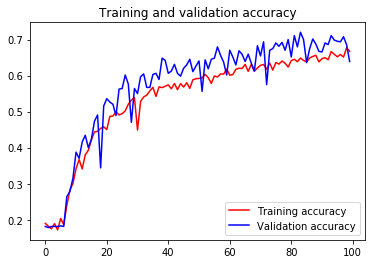

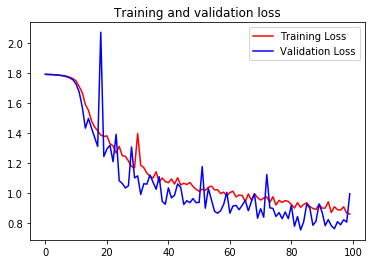

In [66]:
# Plotting Validation and Train Set Accuracy and Loss

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()